### Project Intent ###
 The goal of this project is to predict which NHL teams will make the playoffs for a given season using only each team's day 1 roster. A list of names is not suitable data for modeling, so this project will instead use two models. The first will use player data to predict each player's stats for the following season. The next model will aggregate those predicted player stats to predict playoff status.

## Data Wrangling & Cleaning ##

#### Import Packages ####
Import the standard EDA packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#### Import Data ####
Import, inspect, and clean data. Replace booleans and standardize team names.

In [2]:
# Read the CSV generated by the scraping operation
df = pd.read_csv('nhldata.csv')
df['Playoffs'] = df['Playoffs'].map({True: 1, False: 0})
df.head()

,Player,Age,Pos,GP,G,A,PTS,+/-,PIM,S,S%,OPS,DPS,PS,Team,Playoffs,Season
0,Brian Gionta,27.0,RW,82,48,41,89,18.0,46,291,16.5,8.5,2.9,11.4,NJD,1,2006
1,Scott Gomez,26.0,C,82,33,51,84,8.0,42,244,13.5,6.9,2.4,9.2,NJD,1,2006
2,Jamie Langenbrunner,30.0,RW,80,19,34,53,-1.0,74,243,7.8,2.6,2.0,4.6,NJD,1,2006
3,Brian Rafalski,32.0,D,82,6,43,49,0.0,36,126,4.8,2.9,5.7,8.5,NJD,1,2006
4,Patrik Eliáš,29.0,LW,38,16,29,45,11.0,20,142,11.3,3.9,1.4,5.2,NJD,1,2006


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19183 entries, 0 to 19182
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    19183 non-null  object 
 1   Age       19183 non-null  float64
 2   Pos       19183 non-null  object 
 3   GP        19183 non-null  int64  
 4   G         19183 non-null  int64  
 5   A         19183 non-null  int64  
 6   PTS       19183 non-null  int64  
 7   +/-       19183 non-null  float64
 8   PIM       19183 non-null  int64  
 9   S         19183 non-null  int64  
 10  S%        19183 non-null  float64
 11  OPS       19183 non-null  float64
 12  DPS       19183 non-null  float64
 13  PS        19183 non-null  float64
 14  Team      19183 non-null  object 
 15  Playoffs  19183 non-null  int64  
 16  Season    19183 non-null  int64  
dtypes: float64(6), int64(8), object(3)
memory usage: 2.5+ MB


In [4]:
len(df['Team'].unique())

35

In [5]:
# Standardize teams whose names changed during the target timeframe
team_map = {'ATL': 'WPG', 'PHX': 'ARI', 'MDA': 'ANA'}
df['Team'] = df['Team'].replace(team_map)

In [6]:
len(df['Team'].unique())

32

#### Aggregate Season Statistics ####
Bring together player statistics for each team and each season. These will be the basis of our level 2 model, predicting teams' playoff statuses.

In [7]:
# Custom rounding function to round floats to 1 decimal place
def round_mean(x):
    return round(x.mean(), 1)

In [8]:
# Standard column order for use in future functions
col_order_list = ['Team', 'Season',  'Goals For', 'Total Shots', 'Total PIM', 'Avg Age', 
                  'Team +/-', 'Sum OPS', 'Sum DPS', 'Highest Scorer PTS','Highest G', 
                  'Highest A', 'GP', 'Playoffs']

In [9]:
# Columns to be converted to type int
int_cols = ['Goals For', 'Total Shots', 'Total PIM', 'Team +/-', 'Highest Scorer PTS', 
            'Highest G', 'Highest A', 'GP']

In [10]:
# Create a DataFrame of season-by-season results for each team
def create_team_df(df):

    # Aggregate functions for each column being incorporated
    aggs = {
        'G': 'sum',
        'S': 'sum',
        'PIM': 'sum',
        'Age': round_mean,
        '+/-': 'sum',
        'OPS': 'sum',
        'DPS': 'sum',
        'PTS': 'max',
        'A': 'max',
        'GP': 'max'
        }
    # Create a DataFrame containing summary statistics for each team from each season
    agg_df = df.groupby(['Season', 'Team']).agg(aggs).reset_index()
    
    col_rename_dict = {'G': 'Goals For','S': 'Total Shots', 'PIM': 'Total PIM',
                'Age': 'Avg Age', '+/-': 'Team +/-', 'OPS': 'Sum OPS',
                'DPS': 'Sum DPS', 'PTS': 'Highest Scorer PTS', 'A': 'Highest A'}
    
    top_G = df.groupby(['Season', 'Team']).G.agg(max)
    
    return (
        # Create DataFrame with one entry per team per season
        df.loc[:, ['Team', 'Season', 'Playoffs']]
        .drop_duplicates()
        .reset_index(drop = True)
        # Add summary stats for each team and each season
        .merge(agg_df, on = ['Season', 'Team'], how = 'left')
        .rename(columns = col_rename_dict)
        # Add top goal scorer stat
        .merge(top_G, on = ['Season', 'Team'], how = 'left')
        .rename(columns = {'G': 'Highest G'})
        # Reorder columns and sort alphabetically within each season
        .reindex(columns = col_order_list)
        .sort_values(by = ['Season', 'Team'])
    )

#### Evaluate Aggregates ####
These results make sense on the surface, but the GP column reveals a major issue: shortened seasons.

In [11]:
team_df = create_team_df(df)
team_df.head()

,Team,Season,Goals For,Total Shots,Total PIM,Avg Age,Team +/-,Sum OPS,Sum DPS,Highest Scorer PTS,Highest G,Highest A,GP,Playoffs
26,ANA,2006,251,2585,1445,28.2,126.0,39.3,43.4,90,40,51,82,1
17,ARI,2006,242,2318,1493,27.1,-135.0,36.0,32.1,66,30,41,82,0
2,BOS,2006,228,2511,1162,27.7,-70.0,30.8,32.7,73,31,43,82,0
11,BUF,2006,276,2510,1144,25.9,-8.0,47.5,40.0,73,30,51,82,1
25,CAR,2006,286,2553,1107,28.0,41.0,50.7,34.4,100,45,55,82,1


In [12]:
team_df['GP'].unique()

array([82, 81, 80, 74, 79, 48, 47, 71, 70, 69, 68, 56, 54], dtype=int64)

#### Extrapolate Shortened Seasons ####

Find shortened seasons (due to lockout and COVID) and extrapolate stats to 82 games. This is a simplification, but is better than dropping those years or leaving them unadjusted. I will not be adjusting teams like the 2006 Blue Jackets, who didn't have any individuals play all 82 games, as the team itself still played 82 games so the aggregate stats hold.

In [13]:
# Find seasons where teams played fewer than 72 games (2013 lockout, 2020 COVID, 2021 COVID)
team_df.loc[team_df['GP'] < 72].Season.unique()

array([2013, 2020, 2021], dtype=int64)

In [14]:
def create_adjusted_team_df(team_df):
    
    # List of columns to be adjusted
    scale_cols = ['Goals For', 'Total Shots', 'Total PIM', 'Team +/-', 
                  'Sum OPS', 'Sum DPS', 'Highest Scorer PTS', 'Highest G', 
                  'Highest A', 'GP']
    
    # List of columns that won't be adjusted
    unadjusted_cols = ['Avg Age', 'Playoffs']
    
    # Merge with the adjusted data later to maintain original format
    unadjusted_df = team_df.loc[team_df['GP'] < 72].drop(scale_cols, axis = 1)
    
    
    # Short function to scale each value by 82 divided by the team's GP
    def column_scaler(row):
        return (row * (82 / row['GP'])).round(2)

    # Full season data to be combined later
    full_seasons_df = team_df.loc[team_df['GP'] > 72].reindex(columns = col_order_list)
    
    #DataFrame of adjusted shortened seasons
    adjusted_seasons_df = (
        # Seasons where teams played fewer than 72 games
        team_df.loc[team_df['GP'] < 72]
        .set_index(['Team', 'Season'])
        .drop(unadjusted_cols, axis = 1)
        # Scaling numeric data by the appropriate ratio
        .apply(column_scaler, axis = 1)
        .reset_index(drop = False)
        # Re-combining with unadjusted features
        .merge(unadjusted_df, on = ['Team', 'Season'])
        .reindex(columns = col_order_list)
        )
    
    return (
        # Combine full season data with adjusted shortened season data. Sort for consistency.
        pd.concat([adjusted_seasons_df, full_seasons_df])
        .sort_values(by = ['Season', 'Team'])
        .astype({col: 'int' for col in int_cols})        
    )
    

In [15]:
adjusted_team_df = create_adjusted_team_df(team_df)
adjusted_team_df.head()

,Team,Season,Goals For,Total Shots,Total PIM,Avg Age,Team +/-,Sum OPS,Sum DPS,Highest Scorer PTS,Highest G,Highest A,GP,Playoffs
26,ANA,2006,251,2585,1445,28.2,126,39.3,43.4,90,40,51,82,1
17,ARI,2006,242,2318,1493,27.1,-135,36.0,32.1,66,30,41,82,0
2,BOS,2006,228,2511,1162,27.7,-70,30.8,32.7,73,31,43,82,0
11,BUF,2006,276,2510,1144,25.9,-8,47.5,40.0,73,30,51,82,1
25,CAR,2006,286,2553,1107,28.0,41,50.7,34.4,100,45,55,82,1


In [16]:
# Sanity checks
adjusted_team_df.GP.unique()

array([82, 81, 80, 74, 79])

In [17]:
adjusted_team_df.loc[adjusted_team_df['GP'] < 80]

,Team,Season,Goals For,Total Shots,Total PIM,Avg Age,Team +/-,Sum OPS,Sum DPS,Highest Scorer PTS,Highest G,Highest A,GP,Playoffs
102,NYI,2009,198,2372,1198,26.8,-292,23.9,24.0,56,18,40,74,0
207,NSH,2012,232,2261,677,26.0,53,43.9,40.2,58,27,39,79,1
407,DET,2019,224,2394,625,26.6,-174,30.2,28.4,73,32,41,79,0
505,WSH,2022,270,2577,613,27.6,119,43.2,41.7,90,50,54,79,1


#### Compare Before & After Adjusting for Season Length ####

In [18]:
team_df.describe().round(1)

,Season,Goals For,Total Shots,Total PIM,Avg Age,Team +/-,Sum OPS,Sum DPS,Highest Scorer PTS,Highest G,Highest A,GP,Playoffs
count,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0
mean,2014.6,221.5,2368.4,838.1,26.8,-11.1,36.2,35.2,72.2,32.3,47.1,77.9,0.5
std,5.2,39.3,346.5,263.1,0.9,158.9,10.5,8.8,18.9,9.0,12.6,9.7,0.5
min,2006.0,109.0,1244.0,330.0,24.5,-502.0,6.6,9.0,26.0,11.0,18.0,47.0,0.0
25%,2010.0,205.0,2290.8,646.0,26.1,-122.2,28.9,28.7,60.0,26.0,39.0,82.0,0.0
50%,2015.0,224.0,2434.0,794.5,26.8,2.0,36.4,35.5,70.0,31.0,46.0,82.0,1.0
75%,2019.0,245.0,2579.5,1021.2,27.4,96.0,43.3,41.7,84.0,38.0,55.0,82.0,1.0
max,2023.0,337.0,3062.0,1539.0,30.3,487.0,72.7,59.1,153.0,65.0,92.0,82.0,1.0


In [19]:
adjusted_team_df.describe().round(1)

,Season,Goals For,Total Shots,Total PIM,Avg Age,Team +/-,Sum OPS,Sum DPS,Highest Scorer PTS,Highest G,Highest A,GP,Playoffs
count,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0,548.0
mean,2014.6,232.7,2488.5,876.5,26.8,-11.6,38.1,37.0,75.8,33.9,49.4,81.9,0.5
std,5.2,28.7,173.4,235.4,0.9,167.0,10.0,8.0,17.4,8.4,12.0,0.5,0.5
min,2006.0,150.0,1984.0,450.0,24.5,-575.0,7.6,15.4,38.0,16.0,27.0,74.0,0.0
25%,2010.0,212.0,2370.0,698.0,26.1,-127.2,30.7,32.0,63.0,28.0,41.0,82.0,0.0
50%,2015.0,229.0,2475.5,823.0,26.8,2.0,37.7,36.8,73.0,33.0,48.0,82.0,1.0
75%,2019.0,251.2,2599.2,1038.0,27.4,98.2,45.0,42.7,87.0,39.0,58.0,82.0,1.0
max,2023.0,337.0,3062.0,1539.0,30.3,487.0,72.7,59.1,153.0,65.0,105.0,82.0,1.0


The mean values predictably increased, but most of the values are relatively close to where they originally were. This dataset is a more realistic basis from which to simulate future seasons.

## Exploratory Data Analysis ##
Investigate summary stats and relationships.

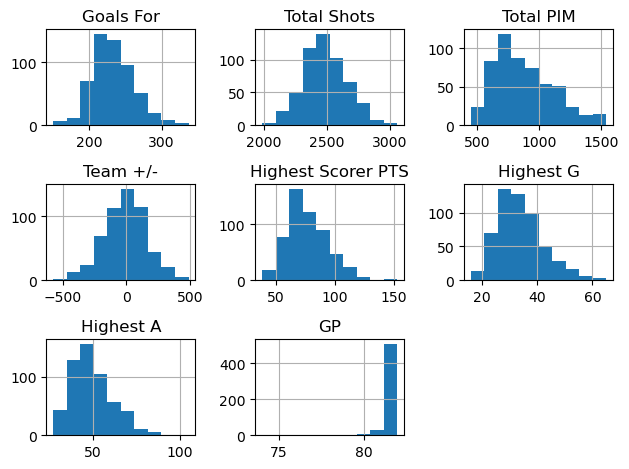

In [20]:
adjusted_team_df[int_cols].hist()
plt.tight_layout()
plt.show()

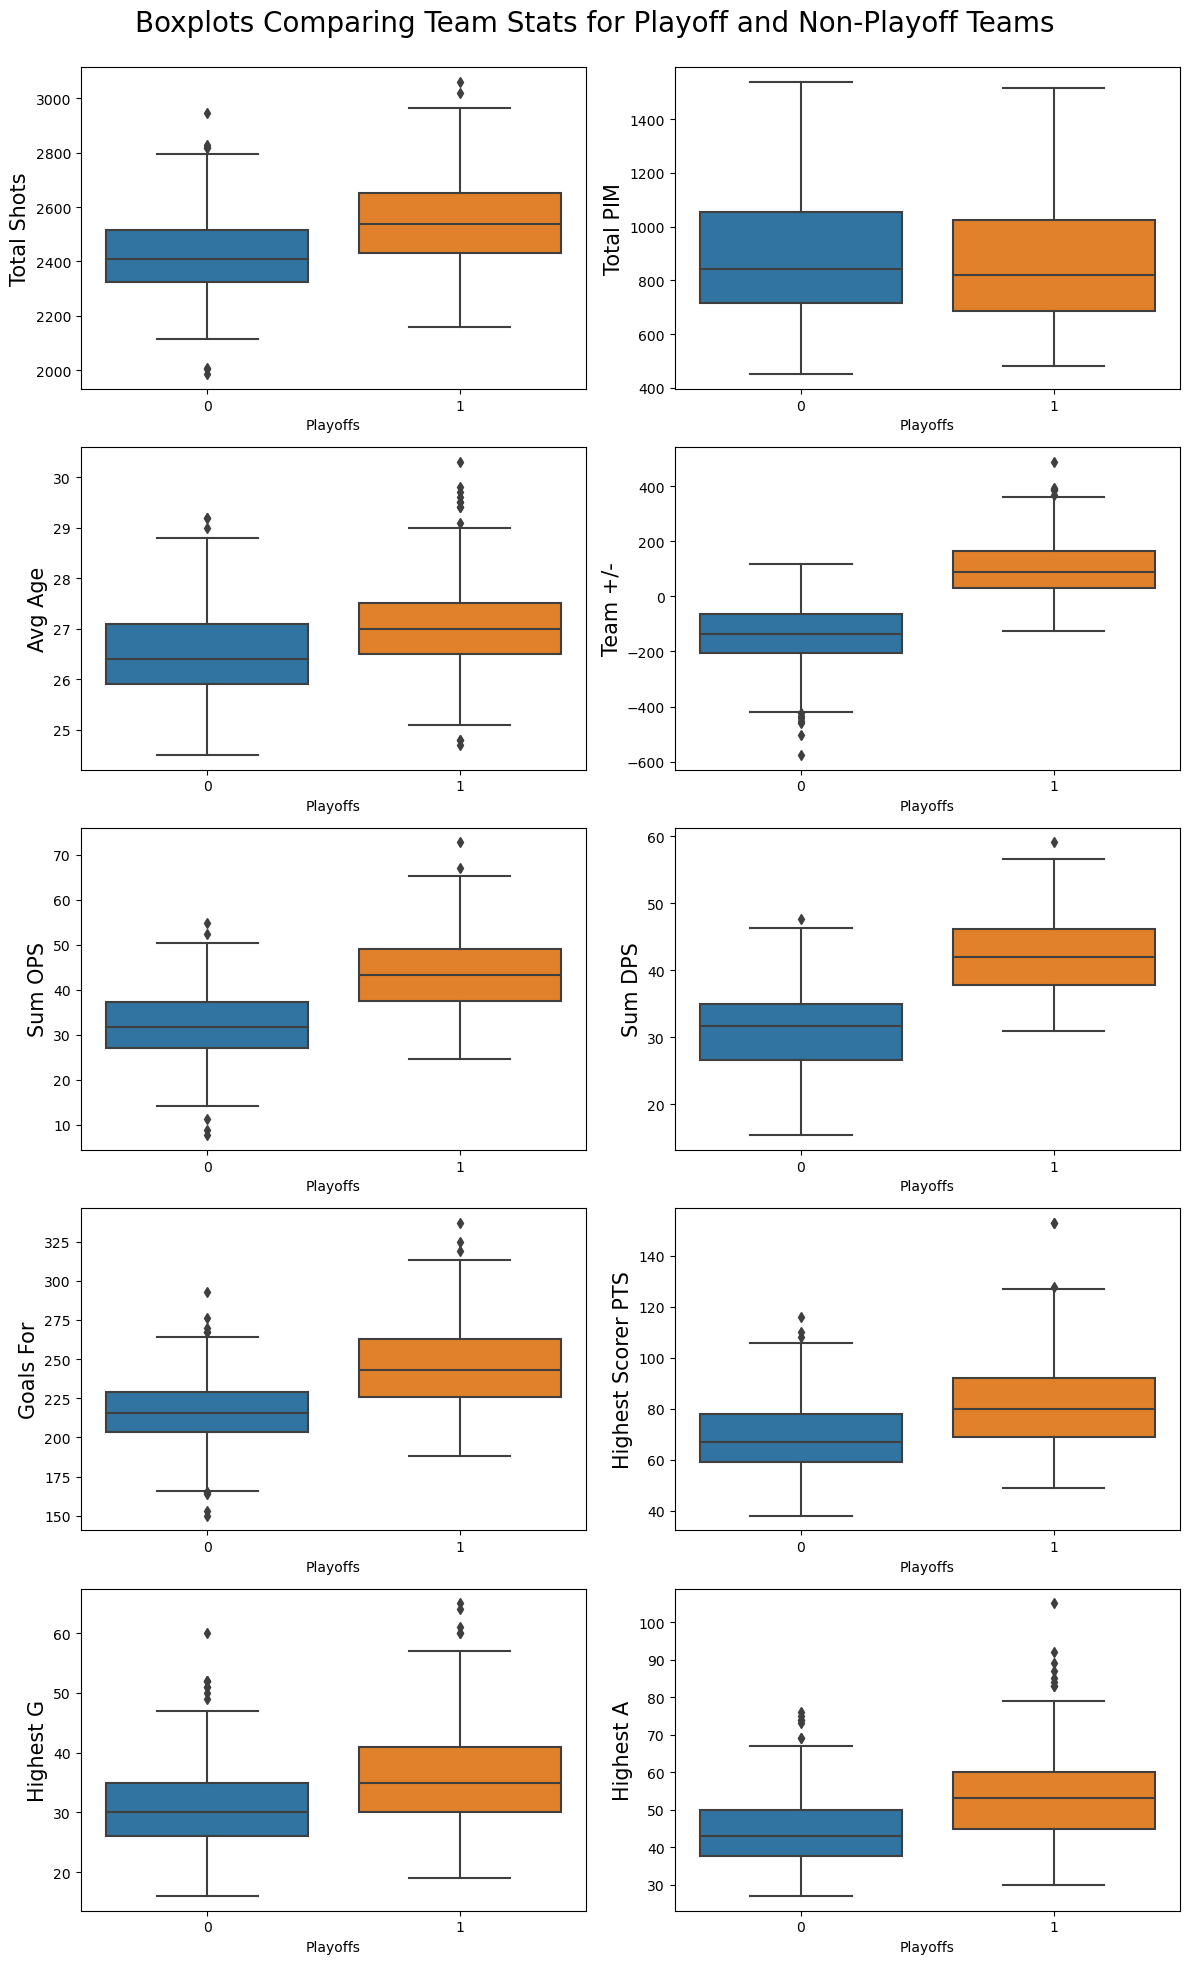

In [21]:
nrows = 5
ncols = 2
columns = [ 'Total Shots', 'Total PIM', 'Avg Age',
       'Team +/-', 'Sum OPS', 'Sum DPS', 'Goals For', 'Highest Scorer PTS', 'Highest G',
       'Highest A']

fig = plt.figure(figsize = (12, 20))
for i, col in enumerate(columns, 1):
    ax = fig.add_subplot(nrows, ncols, i)
    ax.xaxis.label.set_size(10)
    ax.yaxis.label.set_size(15)
    sns.boxplot(data = adjusted_team_df, y = col, x = 'Playoffs', ax = ax)

fig.suptitle('Boxplots Comparing Team Stats for Playoff and Non-Playoff Teams', fontsize = 20)
plt.tight_layout(rect = [0, 0 , 1 , .98])
plt.show()

##### Boxplot Evaluation #####
Playoff teams may take more shots and fewer penalties. There are a lot of low-shooting teams that count as outliers, weighing down the mean. It's probably wisest to use median shots in future visualizations. Could this be an effect of scorekeepers tracking shots more strictly in certain arenas?
Playoff teams are also older, perhaps a sign that experience pays off. They have a higher team +/-, which makes sense since it means they score more even-strength goals than they give up.
It is not particularly surprising that playoff teams also have higher OPS and DPS scores.
It is also not surprising to see that playoff teams score more goals and are generally led by higher-scoring players.

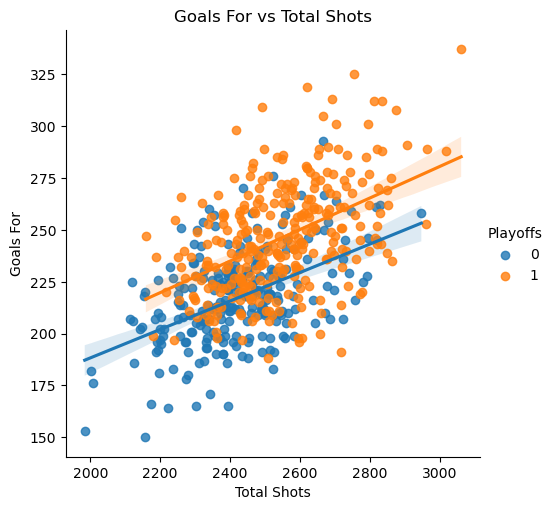

In [22]:
# Taking a look at shots vs. goals. The slope of the regression line is shooting %
sns.lmplot(data = adjusted_team_df, y = 'Goals For', x = 'Total Shots', hue = 'Playoffs')
plt.title('Goals For vs Total Shots')
plt.show()

##### Linear Model Plot Evaluation #####
The slope of the regression line represents the shooting percent. It is seemingly equivalent for playoff and non-playoff teams, so puck luck isn't really explaining the difference between playoff and non-playoff teams. Instead, the playoff cluster centers around a higher mean number of shots.

### Season Aggregation ###
Aggregate season data across all teams, grouping by playoff status. Does a clear divide emerge?

In [23]:
# Come up with season aggregate metrics for each year grouped by playoff status
def create_season_agg_df(adjusted_team_df):

    season_aggs = {
        'Goals For': 'median',
        'Total Shots': 'median',
        'Total PIM': 'median',
        'Avg Age': round_mean,
        'Team +/-': 'median',
        'Sum OPS': 'median',
        'Sum DPS': 'median',
        'Highest Scorer PTS': 'median',
        'Highest A': 'median',
        'Highest G': 'median',
        'GP' : 'max'
        }
    
    agg_col_rename_dict = {'Goals For': 'Median Goals For','Total Shots': 'Median Shots', 
                           'Total PIM': 'Median PIM', 'Avg Age': 'Mean Age', 
                           'Team +/-': 'Median Team +/-', 'Sum OPS': 'Median Sum OPS',
                           'Sum DPS': 'Median Sum DPS', 'Highest Scorer PTS': 'Median Highest Scorer PTS', 
                           'Highest A': 'Median Highest A', 'Highest G': 'Median Highest G'}
    
    return (
        adjusted_team_df.groupby(['Season', 'Playoffs'])
        .agg(season_aggs)
        .astype({col: 'int' for col in int_cols})
        .rename(columns = agg_col_rename_dict)
        .reset_index()
    )

In [24]:
season_agg_df = create_season_agg_df(adjusted_team_df)
season_agg_df.head()

,Season,Playoffs,Median Goals For,Median Shots,Median PIM,Mean Age,Median Team +/-,Median Sum OPS,Median Sum DPS,Median Highest Scorer PTS,Median Highest A,Median Highest G,GP
0,2006,0,233,2376,1387,27.1,-120,32.30,31.50,75,47,32,82
1,2006,1,253,2476,1182,27.6,73,40.05,41.95,87,55,38,82
2,2007,0,218,2365,1216,27.0,-142,31.25,31.95,75,47,30,82
3,2007,1,247,2417,1099,27.5,79,41.95,44.10,94,58,36,82
4,2008,0,215,2367,1108,26.8,-82,34.45,32.25,76,47,35,82


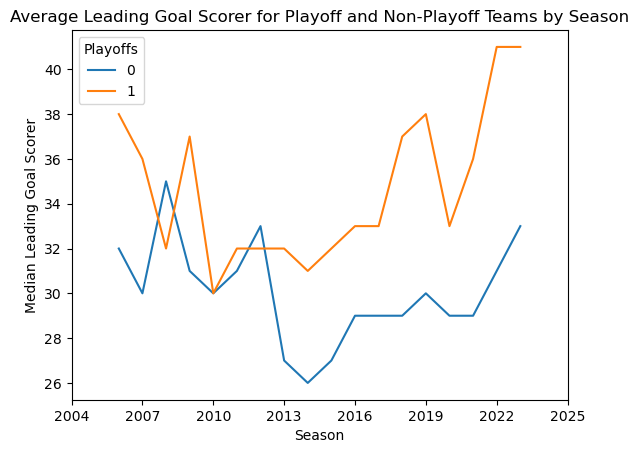

In [25]:
sns.lineplot(data = season_agg_df, x = 'Season', y = 'Median Highest G', hue = 'Playoffs')
plt.xticks(np.arange(2004, 2026, 3))
plt.ylabel('Median Leading Goal Scorer')
plt.title('Average Leading Goal Scorer for Playoff and Non-Playoff Teams by Season')
plt.show()

Leaguewide scoring fell during the late 00's and early 2010's. It has since rebounded. The model will have to account for this when projecting future scoring. For example, some aging players are less productive than when they were in their primes, but their point totals haven't fallen off rapidly because scoring in general is easier now than it was 10 years ago. How does this affect a player like Sidney Crosby's career arc? In terms of points per game, he had a better season at age 35 than at age 27, but what about his performance relative to the pack?
This phenomenon will require some feature engineering.

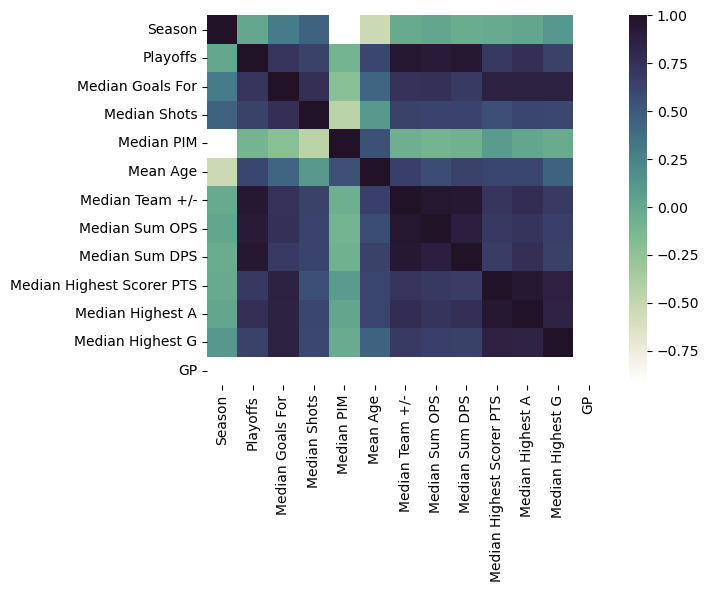

In [26]:
# Correlation heatmap for aggregated season features
sns.heatmap(season_agg_df.corr(), cmap = sns.cubehelix_palette(start=.5, rot=-.75, dark = 0.1,
                                                               light = 1, as_cmap=True))
plt.show()

##### Correlation Heatmap Evaluation #####
The metric of interest in this project is playoff status. Right away, it is apparent that playoff status correlates well with Team +/-, Offensive Point Share (Sum OPS), and Defensive Point Share (DPS). OPS and DPS are well correlated with each other and Team +/- so this isn't a much of a surprise. Playoffs also correlates well with scoring, though it is perhaps noteworthy that Highest Assists correlates more strongly than Highest Scorer or Highest Goals.
Team Goals For correlates well with Highest PTS, Highest G, and Highest A, as well as Total Shots and Playoffs.

### PCA ###
Performing Principal Component Analysis is a good idea when dealing with high-dimensional data. We can look for clusters or patterns that we otherwise can't visualize due to the nature of the dataset. 

In [27]:
def create_y_scaled_X(adjusted_team_df):
    ''' (DataFrame) -> Series, DataFrame
    Returns unscaled Boolean series y and Standardized X DataFrame. 
    
    '''
    from sklearn.preprocessing import StandardScaler
    
    # Create a DataFrame that is ready for scaling
    unscaled_df = (
        adjusted_team_df.set_index(['Team', 'Season'])
        .sort_index()
        .drop(['GP'], axis = 1)
    )
    
    # Preserve column names for reforming the DataFrame
    col_names = unscaled_df.columns
    
    # Preserve playoff status as the 'target' variable. Won't include in PCA.
    y = unscaled_df['Playoffs']
    
    scaler = StandardScaler()
    
    X_arr = scaler.fit_transform(unscaled_df)
    
    # Create scaled DataFrame X
    X = pd.DataFrame(X_arr, columns = col_names).drop('Playoffs', axis = 1)
    
    return y, X

In [28]:
y, X = create_y_scaled_X(adjusted_team_df)

In [29]:
# Sanity check
X.std(ddof = 0)

Goals For             1.0
Total Shots           1.0
Total PIM             1.0
Avg Age               1.0
Team +/-              1.0
Sum OPS               1.0
Sum DPS               1.0
Highest Scorer PTS    1.0
Highest G             1.0
Highest A             1.0
dtype: float64

In [30]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X);

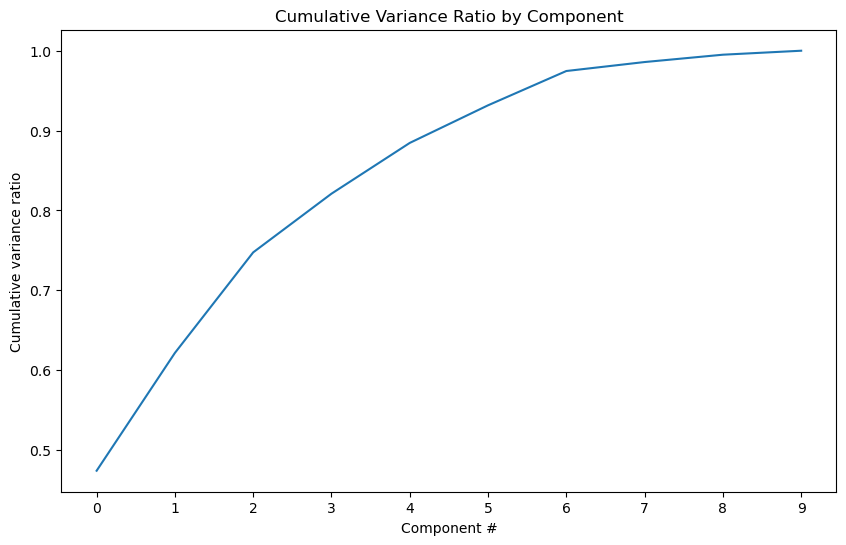

In [31]:
# Visualizing the explained variance
plt.subplots(figsize = (10, 6))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.xticks(np.arange(0, 10))
plt.ylabel('Cumulative variance ratio')
plt.title('Cumulative Variance Ratio by Component')
plt.show()

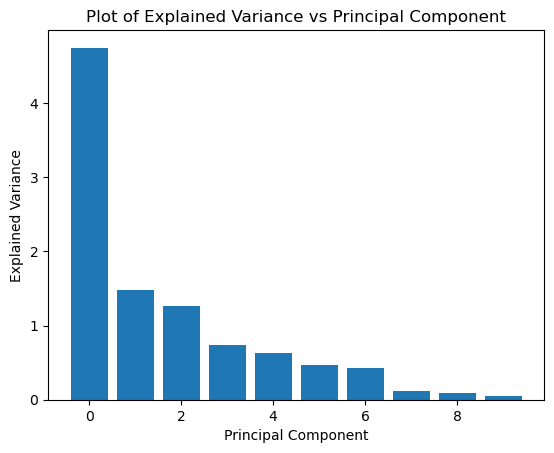

In [32]:
# Visualizing the explained variance a different way
variance = pca.explained_variance_
plt.bar(range(0,len(variance)), variance)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Component')
plt.title('Plot of Explained Variance vs Principal Component')
plt.show()

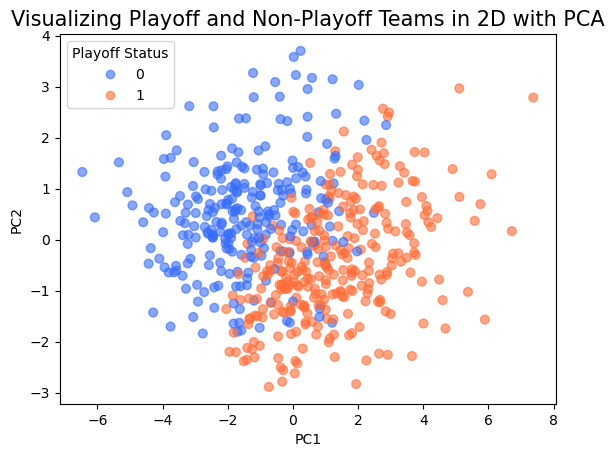

In [33]:
# Visualizing the data in 2d with PCA
from matplotlib.colors import ListedColormap

df_pca = pd.DataFrame(pca.fit_transform(X),
                      columns = [f'PC{i}' for i in range(1, len(X.columns)+1)])

plot_x = df_pca['PC1']
plot_y = df_pca['PC2']

cmap = ListedColormap(sns.color_palette('rainbow').as_hex())

sc = plt.scatter(plot_x, plot_y, s=40, c=y, cmap = cmap, marker='o', alpha=0.6)
plt.xlabel('PC1', fontsize = 10)
plt.ylabel('PC2', fontsize = 10)
plt.title('Visualizing Playoff and Non-Playoff Teams in 2D with PCA', fontsize = 15)
plt.legend(title = 'Playoff Status', *sc.legend_elements(), loc = 'upper left')
plt.show()

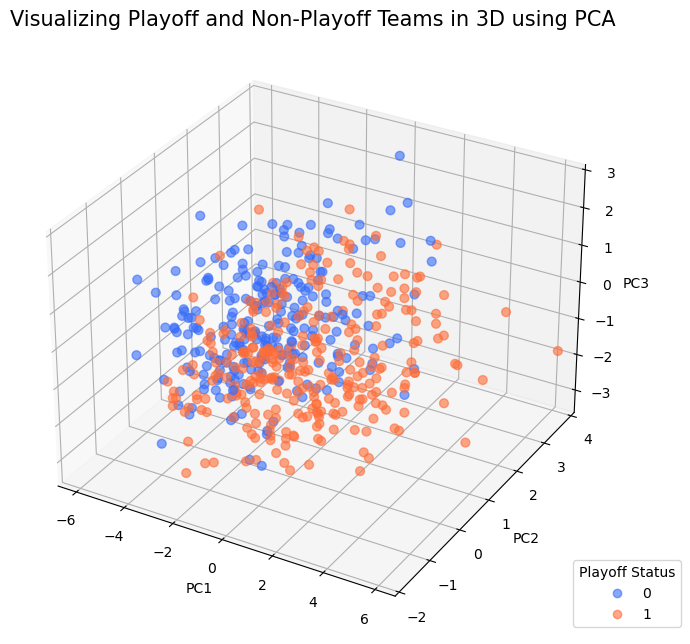

In [34]:
#Visualizing the data in 3D with PCA

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

plot_z = df_pca['PC3']

fig = plt.figure(figsize=(6,8))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
    
sc = ax.scatter(plot_x, plot_y, plot_z, s=40, c=y, cmap = cmap, marker='o', alpha=0.6)
ax.set_xlabel('PC1', fontsize = 10)
ax.set_ylabel('PC2', fontsize = 10)
ax.set_zlabel('PC3', fontsize = 10)
ax.set_xlim(-6.5, 6.5)
ax.set_ylim(-2, 4)
ax.set_zlim(-3.5, 3)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title(f'Visualizing Playoff and Non-Playoff Teams in 3D using PCA', fontsize = 15)
plt.legend(title = 'Playoff Status', *sc.legend_elements(), loc='lower right', bbox_to_anchor=(1.125, 0),
           fontsize = 10, title_fontsize = 10)
plt.show()

#### PCA Results ####
The first 3 principal components explain about 75% of the variance in the dataset. Visualizing the data in 2D and 3D with PCA is promising, as the playoff status clusters are fairly apparent. I'm more confident now that my classification model has enough data to correctly classify teams as long as my player predictions are sound.

### Next Steps ###
* Feature engineering
    * Find players who changed teams mid-season and consolidate stats
* Model experiments

In [35]:
ps = pd.DataFrame(df.groupby(['Player', 'Season']).size())
player_seasons = ps.rename(columns = {0: 'N_teams'})
player_seasons.loc[player_seasons['N_teams'] == np.max(player_seasons['N_teams'])]

,,N_teams
Player,Season,
Jussi Jokinen,2018,4
Mark Arcobello,2015,4


In [36]:
player_seasons.loc[player_seasons['N_teams'] > 1]

N_teams
Player            Season         
Aaron Downey      2006          2
Aaron Johnson     2010          2
Aaron Volpatti    2013          2
Aaron Ward        2007          2
                  2010          2
...                           ...
Zenon Konopka     2014          2
Éric Bélanger     2007          2
                  2010          2
Éric Gélinas      2016          2
Ľubomír Višňovský 2010          2

[1397 rows x 1 columns]